# Variational AutoEncoders - MNIST with TensorFlow2

[Reference](https://keras.io/examples/generative/vae/)

In [1]:
import tensorflow as tf
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.6.0


In [3]:
# Get number of available GPUs-
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"number of GPUs available = {num_gpus}")

number of GPUs available = 1


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080 Laptop GPU


### Data preprocessing and cleaning:

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [7]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (28, 28, 1)


In [8]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 100

In [9]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [10]:
# By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks
# work best when each input is inside the range –1 to 1, so we need to divide by 255.

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [11]:
# Convert class vectors/target to binary class matrices or one-hot encoded values-
# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [11]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (60000, 28, 28, 1), y_train.shape: (60000,)
X_test.shape: (10000, 28, 28, 1), y_test.shape: (10000,)


In [12]:
class Sampling(layers.Layer):
    """
    Create a sampling layer.
    Uses (z_mean, z_log_var) to sample z - the vector encoding a digit.
    """

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [13]:
# Specify latent space-
latent_dim = 3

### Create _encoder_

In [14]:
encoder_inputs = Input(shape = (28, 28, 1))

x = Conv2D(
    filters = 32, kernel_size = (3, 3),
    activation = "relu" , strides = 2,
    padding="same")(encoder_inputs)

x = Conv2D(
    filters = 64, kernel_size = (3, 3),
    activation = "relu", strides = 2,
    padding = "same")(x)

x = Flatten()(x)

x = Dense(units = 16, activation = "relu")(x)

z_mean = Dense(units = latent_dim, name = "z_mean")(x)
z_log_var = layers.Dense(units = latent_dim, name = "z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

In [15]:
encoder = Model(inputs = encoder_inputs, outputs = [z_mean, z_log_var, z], name = "encoder")

In [16]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [17]:
# Sanity check-
l = encoder(X_train[:5, :])

In [18]:
type(l), len(l)

(list, 3)

In [19]:
for x in l:
    print(f"shape: {x.shape}")

shape: (5, 3)
shape: (5, 3)
shape: (5, 3)


In [20]:
l[0].numpy()

array([[-0.01216803, -0.01785355, -0.09443256],
       [-0.07006311, -0.00863914, -0.0540884 ],
       [-0.04860036,  0.00742457, -0.02787741],
       [-0.00783078, -0.00117484, -0.06881581],
       [-0.05342957,  0.01560506, -0.06613626]], dtype=float32)

### Create _decoder_

In [21]:
latent_inputs = Input(shape = (latent_dim,))

x = layers.Dense(units = 7 * 7 * 64, activation = "relu")(latent_inputs)

x = layers.Reshape((7, 7, 64))(x)

x = Conv2DTranspose(
    filters = 64, kernel_size = (3, 3),
    activation = "relu", strides = 2,
    padding = "same")(x)

x = Conv2DTranspose(
    filters = 32, kernel_size = (3, 3),
    activation = "relu", strides = 2,
    padding = "same")(x)

decoder_outputs = Conv2DTranspose(
    filters = 1, kernel_size = (3, 3),
    activation = "sigmoid", padding = "same")(x)

In [22]:
decoder = Model(inputs = latent_inputs, outputs = decoder_outputs, name = "decoder")

In [23]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_______________________________________________________

In [24]:
# Sanity check-
x_hat = decoder(l[0])

In [25]:
x_hat.shape

TensorShape([5, 28, 28, 1])

In [26]:
del l, x_hat

In [29]:
import tensorflow
from tensorflow import keras

In [30]:
class VAE(keras.Model):
    """
    VAE as a 'Model' with a custom 'train_step()' method.
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name = "total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name = "reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name = "kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
 
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, data):
        loss_obj = self.train_step(data)
        return loss_obj


In [31]:
# Initialize VAE model-
vae_model = VAE(encoder, decoder)

In [32]:
# Compile instantiated model-
vae_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
)

In [33]:
# Sanity check-
loss_dict = vae_model(X_train[:5, :])

In [34]:
print(f"loss = {loss_dict['loss'].numpy():.4f},"
      f" reconstruction loss = {loss_dict['reconstruction_loss'].numpy():.4f}"
      f" & KL-loss = {loss_dict['kl_loss'].numpy():.4f}"
     )

loss = 543.2289, reconstruction loss = 543.2248 & KL-loss = 0.0041


In [36]:
vae_model.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         [(None, 3), (None, 3), (N 69110     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         68225     
Total params: 137,341
Trainable params: 137,335
Non-trainable params: 6
_________________________________________________________________


In [37]:
# Count number of trainable parameters-
tot_params = 0

for layer in vae_model.trainable_weights:
    loc_param = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_param
    print(f"layer.shape: {layer.shape} has {loc_param} parameters")

layer.shape: (3, 3, 1, 32) has 288 parameters
layer.shape: (32,) has 32 parameters
layer.shape: (3, 3, 32, 64) has 18432 parameters
layer.shape: (64,) has 64 parameters
layer.shape: (3136, 16) has 50176 parameters
layer.shape: (16,) has 14 parameters
layer.shape: (16, 3) has 48 parameters
layer.shape: (3,) has 3 parameters
layer.shape: (16, 3) has 48 parameters
layer.shape: (3,) has 3 parameters
layer.shape: (3, 3136) has 9408 parameters
layer.shape: (3136,) has 3136 parameters
layer.shape: (3, 3, 64, 64) has 36864 parameters
layer.shape: (64,) has 64 parameters
layer.shape: (3, 3, 32, 64) has 18432 parameters
layer.shape: (32,) has 32 parameters
layer.shape: (3, 3, 1, 32) has 288 parameters
layer.shape: (1,) has 1 parameters


In [38]:
print(f"VAE model has {tot_params} trainable parameters")

VAE model has 137333 trainable parameters


In [98]:
'''
# Define early stopping criterion-
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.0001,
    patience = 4,
    restore_best_weights = True
)
# Adjust 'min_delta' according to training loss for early stopping
# to effectively happen.
'''

In [39]:
num_epochs = 30
print(f"number of training epochs = {num_epochs}")

number of training epochs = 30


In [ ]:
'''
# Train Variational Autoencoder-
training_hist = vae_model.fit(
    x = X_train, y = X_train,
    batch_size = batch_size, shuffle = True,
    validation_data = (X_test, X_test),
    epochs = num_epochs, callbacks = [early_stopping]
    )
'''

In [ ]:
# Train Variational Autoencoder-
training_hist = vae_model.fit(
    X_train,
    epochs = num_epochs, batch_size = batch_size,
    shuffle = True
)

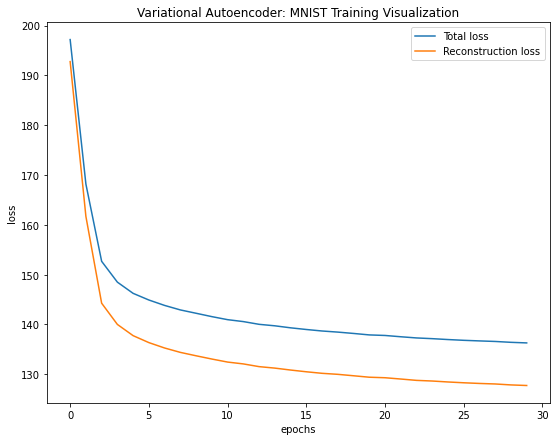

In [47]:
# Visualize training wrt loss-
plt.figure(figsize = (9, 7))
plt.plot(training_hist.history['loss'], label = 'Total loss')
plt.plot(training_hist.history['reconstruction_loss'], label = 'Reconstruction loss')
# plt.plot(training_hist.history['kl_loss'], label = 'KL loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Variational Autoencoder: MNIST Training Visualization")
plt.show()

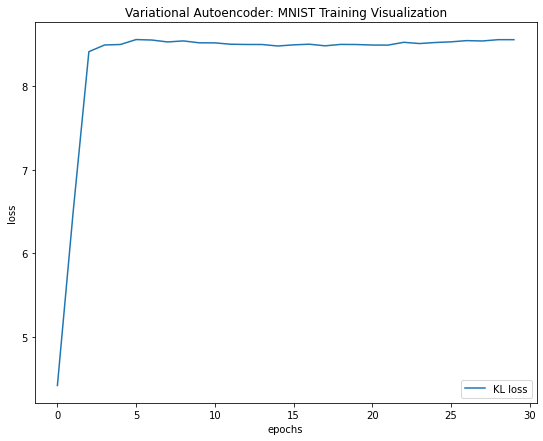

In [48]:
plt.figure(figsize = (9, 7))
plt.plot(training_hist.history['kl_loss'], label = 'KL loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Variational Autoencoder: MNIST Training Visualization")
plt.show()

In [49]:
# Save trained VAE weights-
vae_model.save_weights("Trained_VAE_MNIST_model.h5", overwrite = True)

In [35]:
# Load pre-trained VAE weights-
# vae_model.load_weights("Trained_VAE_MNIST_model.h5")

### Visualize a grid of _sampled_ digits:

In [67]:
def plot_latent_space(vae, n = 30, figsize = 15):
    # Display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space-
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    grid_z = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            for k, zi in enumerate(grid_z):
                z_sample = np.array([[xi, yi, zi]])
                x_decoded = vae.decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                ] = digit

    plt.figure(figsize = (figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap = "Greys_r")
    plt.show()

    return None


In [54]:
scale = 1.0
digit_size = 28
n = 30
figure = np.zeros((digit_size * n, digit_size * n))
    
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space-
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]
grid_z = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        for k, zi in enumerate(grid_z):
            break

In [57]:
xi, yi, zi

(1.0, -1.0, 1.0)

In [58]:
z_sample = np.array([[xi, yi, zi]])

In [59]:
z_sample.shape

(1, 3)

In [60]:
z_sample

array([[ 1., -1.,  1.]])

In [61]:
x_decoded = vae_model.decoder.predict(z_sample)

In [62]:
x_decoded.shape

(1, 28, 28, 1)

In [63]:
digit = x_decoded[0].reshape(digit_size, digit_size)
digit.shape

(28, 28)

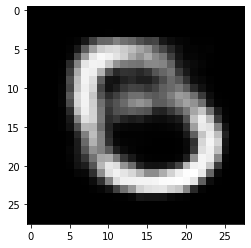

In [64]:
plt.imshow(digit, cmap = "Greys_r")
plt.show()

In [ ]:
plot_latent_space(vae_model)

### Visualize - _latent space mean_, _latent space log variance_ & _latent space_

In [37]:
z_mean, z_log_var, z = vae_model.encoder.predict(X_train)

In [38]:
z_mean.shape, z_log_var.shape, z.shape

((60000, 3), (60000, 3), (60000, 3))

In [ ]:
# Visualize z_mean-
fig = px.scatter_3d(
    x = z_mean[:, 0], y = z_mean[:, 1],
    z = z_mean[:, 2],
    color = y_train
    )
fig.show()

In [ ]:
# Visualize z_log_var-
fig = px.scatter_3d(
    x = z_log_var[:, 0], y = z_log_var[:, 1],
    z = z_log_var[:, 2],
    color = y_train
    )
fig.show()

In [ ]:
# Visualize z-
fig = px.scatter_3d(
    x = z[:, 0], y = z[:, 1],
    z = z[:, 2],
    color = y_train
    )
fig.show()